In [1]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.misc import imresize
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.label_maps import CLASS_DICT
from user_constants import DATA_PATH_DICT
%matplotlib inline

In [2]:
# Constants
DATA = 'RestrictedImageNet' # Choices: ['RestrictedImageNet']
BATCH_SIZE = 10
NUM_WORKERS = 8
SR_FACTOR_RIN = 8

DATA_SHAPE = 32 if DATA == 'CIFAR' else 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)
CLASSES = CLASS_DICT[DATA] # Class names for dataset
NUM_CLASSES = len(CLASSES) - 1

In [3]:
# Load dataset
dataset_function = getattr(datasets, DATA)
dataset = dataset_function(DATA_PATH_DICT[DATA])
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS, 
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)
data_iterator = enumerate(test_loader)

==> Preparing dataset restricted_imagenet..


In [4]:
cifar_dataset = datasets.CIFAR(DATA_PATH_DICT['CIFAR'])
cifar_loader, _ = cifar_dataset.make_loaders(workers=NUM_WORKERS, 
                                     batch_size=BATCH_SIZE, 
                                     data_aug=False)

0it [00:00, ?it/s]

==> Preparing dataset cifar..


170500096it [00:02, 57680322.66it/s]                               


Files already downloaded and verified


In [5]:
# Load model
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': f'./models/{DATA}.pt'
}

model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()

=> loading checkpoint './models/RestrictedImageNet.pt'
=> loaded checkpoint './models/RestrictedImageNet.pt' (epoch 61)


DataParallel(
  (module): AttackerModel(
    (normalizer): InputNormalize()
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): SequentialWithArgs(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runni

In [6]:
def downsample(x, step=None):
    down = ch.zeros([len(x), 3, 224//step, 224//step])

    for i in range(0, 224, step):
        for j in range(0, 224, step):
            v = x[:, :, i:i+step, j:j+step].mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            ii, jj = i // step, j // step
            down[:, :, ii:ii+1, jj:jj+1] = v
    return down

def upsample(x, step=None):
    up = ch.zeros([len(x), 3, 224, 224])
    for i in range(0, 224, step):
        for j in range(0, 224, step):
            ii, jj = i // step, j // step
            up[:, :, i:i+step, j:j+step] = x[:, :, ii:ii+1, jj:jj+1]
    return up

## CIFAR Superresolution (32x32 -> 224x224)

In [7]:
# Get a batch of CIFAR images with classes in RestrictedImageNet

img_cifar, targ_cifar = [], []
cifar_to_in_dict = {
    2: 4, 3: 1, 5: 0, 6: 2
}

for _, (im, targ) in enumerate(cifar_loader):        
    for i in range(len(targ)):
        if len(img_cifar) >= BATCH_SIZE: 
            break
        elif targ[i].item() in cifar_to_in_dict.keys():
            img_cifar.append(im[i])
            targ_cifar.append(ch.tensor(cifar_to_in_dict[targ[i].item()], dtype=targ.dtype))
img_cifar, targ_cifar = ch.stack(img_cifar), ch.stack(targ_cifar)

In [8]:
# PGD Parameters
kwargs = {
        'constraint':'2',
        'eps': 15,
        'step_size': 1,
        'iterations': 50,
        'do_tqdm':True,
        'targeted': True,
        'should_normalize': True
}

In [9]:
# Superresolution using PGD
img_cifar_up = upsample(img_cifar, step=7)
_, img_cifar_sr = model(img_cifar_up, targ_cifar, fake_relu=False, make_adv=True, **kwargs)

In [10]:
# Bicubic upsampling baseline
img_bicubic = np.stack([imresize(i, size=(224, 224, 3), interp='bicubic') 
                        for i in img_cifar.numpy()]).transpose(0, 3, 1, 2) / 255.
img_bicubic = ch.tensor(img_bicubic)

/data/theory/robustopt/engstrom/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


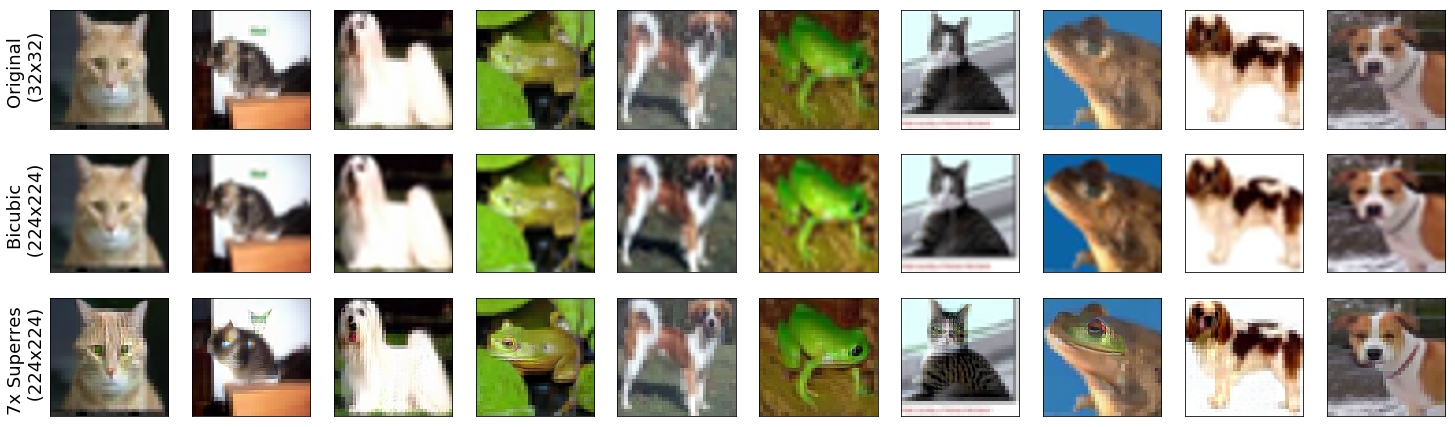

In [11]:
# Visualize superres results
show_image_row([img_cifar.cpu(), img_bicubic.cpu(), img_cifar_sr.detach().cpu()], 
               ['Original \n (32x32)', 'Bicubic \n (224x224)', '7x Superres \n (224x224)'],
               fontsize=18)

## RestrictedImageNet Superresolution (28x28 -> 224x224)

In [12]:
# PGD Parameters
kwargs = {
        'constraint':'2',
        'eps': 8,
        'step_size': 1,
        'iterations': 40,
        'targeted': True,
        'should_normalize': True

}

In [13]:
# Construct low-res images by downsampling
_, (img_rin, targ_rin) = next(enumerate(test_loader))
img_lr = upsample(downsample(img_rin, step=SR_FACTOR_RIN), step=SR_FACTOR_RIN)

In [14]:
# Superresolution using PGD
_, img_sr = model(img_lr, targ_rin, fake_relu=True, make_adv=True, **kwargs)

In [15]:
# Bicubic upsampling baseline
img_bicubic = np.stack([imresize(i, size=(224, 224, 3), interp='bicubic') 
                        for i in img_lr.numpy()]).transpose(0, 3, 1, 2) / 255.
img_bicubic = ch.tensor(img_bicubic)

/data/theory/robustopt/engstrom/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


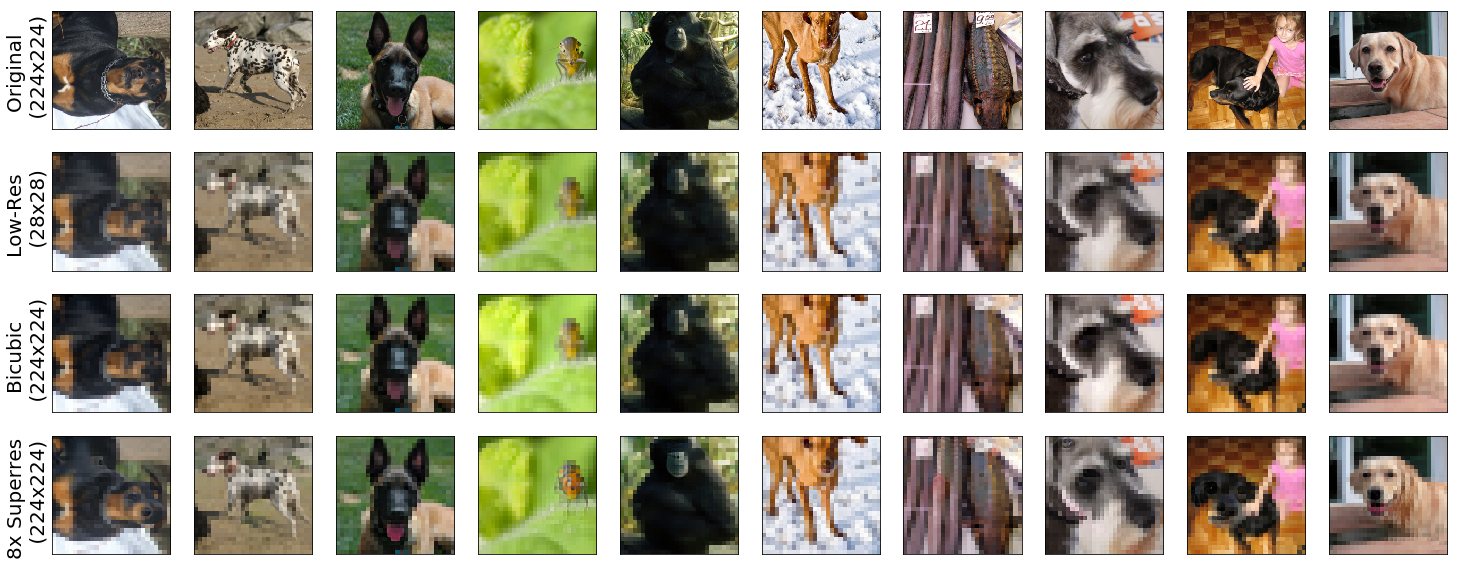

In [16]:
# Visualize superres results
show_image_row([img_rin.cpu(), img_lr.cpu(), img_bicubic.cpu(), img_sr.detach().cpu()],
               ["Original \n (224x224)", "Low-Res \n (28x28)", "Bicubic \n (224x224)", "8x Superres \n (224x224)"],
               fontsize=20)